Mounted at /content/drive


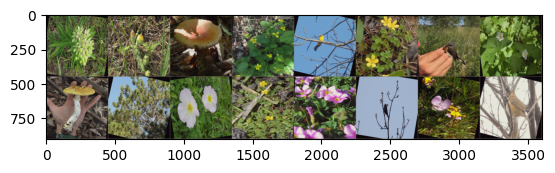

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
from PIL import Image
from torch.utils.data import Dataset
import glob

from google.colab import drive
drive.mount('/content/drive')

import zipfile

zip_path = '/content/drive/MyDrive/your_dataset.zip'
extract_path = 'data/your_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Set seed
RANDOM_SEED = 0
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

plt.ion()   # interactive mode

# Define transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((460, 460)),
        transforms.RandomRotation(15),
        transforms.RandomCrop(448),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((448, 448)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'test': transforms.Compose([
        transforms.Resize((448, 448)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}


data_dir = 'data/your_dataset'

# Load train and valid sets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'valid']}

# Custom Dataset for unlabeled test images
class UnlabeledImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = sorted(glob.glob(os.path.join(root_dir, '*')))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, os.path.basename(self.image_paths[idx])

# Load test set
test_dataset = UnlabeledImageDataset(os.path.join(data_dir, 'test'), transform=data_transforms['test'])

# Wrap DataLoaders
BATCH_SIZE = 16
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=4),
    'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=BATCH_SIZE, shuffle=True, num_workers=4),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
}

# Dataset sizes
dataset_sizes = {
    'train': len(image_datasets['train']),
    'valid': len(image_datasets['valid']),
    'test': len(test_dataset)
}

class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# imshow() function
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Preview training images
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out)  # title=[class_names[x] for x in classes]


Showing 64 images when batch_size=64.

In [ ]:
from torch.cuda.amp import autocast, GradScaler
import time
import copy
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import timm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, top_k_accuracy_score
import numpy as np
import torch.nn.functional as F
import torch

# ====== 0. Set up TensorBoard writer ======
tb_writer = SummaryWriter(log_dir='runs/exp1')
os.makedirs("figures", exist_ok=True)

# ====== 1. Model backbone + SpinalNet head ======
class SpinalNet_ResNet(nn.Module):
    def __init__(self, num_ftrs, Num_class):
        super(SpinalNet_ResNet, self).__init__()
        half_in_size = round(num_ftrs / 2)
        layer_width = 540
        self.half_in_size = half_in_size

        self.fc_spinal_layer1 = nn.Sequential(
            nn.Dropout(p=0.5), nn.Linear(half_in_size, layer_width), nn.ReLU(inplace=True))
        self.fc_spinal_layer2 = nn.Sequential(
            nn.Dropout(p=0.5), nn.Linear(half_in_size + layer_width, layer_width), nn.ReLU(inplace=True))
        self.fc_spinal_layer3 = nn.Sequential(
            nn.Dropout(p=0.5), nn.Linear(half_in_size + layer_width, layer_width), nn.ReLU(inplace=True))
        self.fc_spinal_layer4 = nn.Sequential(
            nn.Dropout(p=0.5), nn.Linear(half_in_size + layer_width, layer_width), nn.ReLU(inplace=True))
        self.fc_out = nn.Sequential(
            nn.Dropout(p=0.5), nn.Linear(layer_width * 4, Num_class))

    def forward(self, x):
        x1 = self.fc_spinal_layer1(x[:, 0:self.half_in_size])
        x2 = self.fc_spinal_layer2(torch.cat([x[:, self.half_in_size:], x1], dim=1))
        x3 = self.fc_spinal_layer3(torch.cat([x[:, 0:self.half_in_size], x2], dim=1))
        x4 = self.fc_spinal_layer4(torch.cat([x[:, self.half_in_size:], x3], dim=1))
        x = torch.cat([x1, x2, x3, x4], dim=1)
        return self.fc_out(x)

class ResNeXt101_SpinalNet(nn.Module):
    def __init__(self, Num_class):
        super(ResNeXt101_SpinalNet, self).__init__()
        self.backbone = timm.create_model('resnest50d', pretrained=True, num_classes=0, global_pool='avg')
        num_ftrs = self.backbone.num_features
        self.spinal = SpinalNet_ResNet(num_ftrs, Num_class)

    def forward(self, x):
        x = self.backbone(x)
        return self.spinal(x)

Num_class = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = ResNeXt101_SpinalNet(Num_class).to(device)

# ====== Load pretrained weights from checkpoint_resume.pth ======
resume_path = "/content/checkpoint_resume.pth"
if os.path.exists(resume_path):
    print("Loading pretrained weights from checkpoint_resume.pth...")
    state_dict = torch.load(resume_path, map_location=device)
    model_ft.load_state_dict(state_dict)
    print("Pretrained weights loaded successfully!")
else:
    print("checkpoint_resume.pth not found.")

# ====== 2. EarlyStopping Class ======
class EarlyStopping:
    def __init__(self, patience=8, verbose=False):
        self.patience = patience
        self.counter = 0
        self.best_acc = None
        self.early_stop = False
        self.verbose = verbose
        self.best_weights = None

    def __call__(self, val_acc, model):
        if self.best_acc is None or val_acc > self.best_acc:
            self.best_acc = val_acc
            self.counter = 0
            self.best_weights = copy.deepcopy(model.state_dict())

            # Save best checkpoint and trigger download
            torch.save(model.state_dict(), "checkpoint_best.pth")
            print(f"Checkpoint updated: val_acc = {val_acc:.4f}, saved as checkpoint_best.pth")
            # 自動儲存到 Google Drive
            ckpt_path = "/content/drive/MyDrive/best_model.pth"
            torch.save(model.state_dict(), ckpt_path)
            print(f"Checkpoint saved to {ckpt_path}")

        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

# ====== 3. Mixup & Label Smoothing Loss ======
class SoftTargetCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(SoftTargetCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, x, target):
        target = F.one_hot(target, num_classes=x.shape[1]).float()
        target = target * (1 - self.smoothing) + self.smoothing / x.shape[1]
        return torch.mean(torch.sum(-target * F.log_softmax(x, dim=-1), dim=-1))

def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ====== 4. Train function ======
def train_model(model, criterion, optimizer, scheduler, num_epochs=50, patience=8, alpha=1.0):
    since = time.time()
    early_stopper = EarlyStopping(patience=patience, verbose=True)
    scaler = GradScaler()

    train_acc_hist, valid_acc_hist = [], []
    train_loss_hist, valid_loss_hist = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        print(f"Epoch {epoch}: Mixup alpha = {alpha}")

        for phase in ['train', 'valid']:
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).long()
                optimizer.zero_grad()

                if phase == 'train':
                    inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=alpha)

                with autocast():
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
                    else:
                        loss = criterion(outputs, labels)

                if phase == 'train':
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)
                if phase == 'valid':
                    all_preds.extend(outputs.detach().cpu().numpy())
                    all_labels.extend(labels.detach().cpu().numpy())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            tb_writer.add_scalar(f"{phase}/Loss", epoch_loss, epoch)
            tb_writer.add_scalar(f"{phase}/Accuracy", epoch_acc, epoch)

            if phase == 'train':
                train_loss_hist.append(epoch_loss)
                train_acc_hist.append(epoch_acc.item())
            else:
                valid_loss_hist.append(epoch_loss)
                valid_acc_hist.append(epoch_acc.item())
                early_stopper(epoch_acc, model)
                if early_stopper.early_stop:
                    print("Early stopping triggered!")
                    model.load_state_dict(early_stopper.best_weights)
                    plot_training(train_loss_hist, valid_loss_hist, train_acc_hist, valid_acc_hist)
                    evaluate_model(model, all_preds, all_labels)
                    return model

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {early_stopper.best_acc:.4f}')
    model.load_state_dict(early_stopper.best_weights)
    plot_training(train_loss_hist, valid_loss_hist, train_acc_hist, valid_acc_hist)
    evaluate_model(model, all_preds, all_labels)
    return model

# ====== 5. Plotting Function and Save Figure ======
def plot_training(train_loss, valid_loss, train_acc, valid_acc):
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, valid_loss, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Acc')
    plt.plot(epochs, valid_acc, label='Valid Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.savefig("figures/training_curves.png")
    plt.show()
    print("Saved training curve to figures/training_curves.png")

# ====== 6. Evaluation (Confusion Matrix + Top-k Accuracy) ======
def evaluate_model(model, all_outputs, all_labels):
    preds_top1 = np.argmax(all_outputs, axis=1)
    cm = confusion_matrix(all_labels, preds_top1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(xticks_rotation='vertical', cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig("figures/confusion_matrix.png")
    plt.show()
    print("Saved confusion matrix to figures/confusion_matrix.png")

    top1 = top_k_accuracy_score(all_labels, all_outputs, k=1)
    top5 = top_k_accuracy_score(all_labels, all_outputs, k=5)
    print(f"Top-1 Accuracy: {top1:.4f}")
    print(f"Top-5 Accuracy: {top5:.4f}")

# ====== 7. Optimizer, Scheduler, Training ======
criterion = SoftTargetCrossEntropy(smoothing=0.1)

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=50)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50, patience=10, alpha=1.0)

torch.save(model_ft.state_dict(), "best_model_first.pth")
print("Model saved as best_model_first.pth")
from google.colab import files
files.download("best_model_first.pth")

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=20)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30, patience=10, alpha=0.2)

torch.save(model_ft.state_dict(), "best_model_second.pth")
print("Model saved as best_model_second.pth")
files.download("best_model_second.pth")


optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=20)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30, patience=10, alpha=0)

torch.save(model_ft.state_dict(), "best_model_third.pth")
print("Model saved as best_model_third.pth")
files.download("best_model_third.pth")



# 預測


In [ ]:
import torch
from torchvision import transforms, datasets
from PIL import Image
import glob
import os
import pandas as pd
from tqdm import tqdm
import timm
import torch.nn as nn
from google.colab import files

# ========= 設定參數 =========
test_dir = 'data/your_dataset/test'           # 測試資料夾
train_dir = 'data/your_dataset/train'         # 訓練資料夾（用來抓 class_names）
model_path = 'checkpoint_best.pth'          # 訓練好的模型權重
output_csv = 'prediction.csv'                 # 輸出結果檔
Num_class = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========= 讀取類別名稱 =========
class_names = datasets.ImageFolder(train_dir).classes

# ========= 資料前處理（與訓練一致）=========
transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

# ========= SpinalNet 結構 =========
class SpinalNet_ResNet(nn.Module):
    def __init__(self, num_ftrs, Num_class):
        super(SpinalNet_ResNet, self).__init__()
        half_in_size = round(num_ftrs / 2)
        layer_width = 540
        self.half_in_size = half_in_size

        self.fc_spinal_layer1 = nn.Sequential(
            nn.Dropout(p=0.5), nn.Linear(half_in_size, layer_width), nn.ReLU(inplace=True))
        self.fc_spinal_layer2 = nn.Sequential(
            nn.Dropout(p=0.5), nn.Linear(half_in_size + layer_width, layer_width), nn.ReLU(inplace=True))
        self.fc_spinal_layer3 = nn.Sequential(
            nn.Dropout(p=0.5), nn.Linear(half_in_size + layer_width, layer_width), nn.ReLU(inplace=True))
        self.fc_spinal_layer4 = nn.Sequential(
            nn.Dropout(p=0.5), nn.Linear(half_in_size + layer_width, layer_width), nn.ReLU(inplace=True))
        self.fc_out = nn.Sequential(
            nn.Dropout(p=0.5), nn.Linear(layer_width * 4, Num_class))

    def forward(self, x):
        x1 = self.fc_spinal_layer1(x[:, 0:self.half_in_size])
        x2 = self.fc_spinal_layer2(torch.cat([x[:, self.half_in_size:], x1], dim=1))
        x3 = self.fc_spinal_layer3(torch.cat([x[:, 0:self.half_in_size], x2], dim=1))
        x4 = self.fc_spinal_layer4(torch.cat([x[:, self.half_in_size:], x3], dim=1))
        x = torch.cat([x1, x2, x3, x4], dim=1)
        return self.fc_out(x)

# ========= ResNeSt50d + SpinalNet =========
class ResNeSt50d_SpinalNet(nn.Module):
    def __init__(self, Num_class):
        super().__init__()
        self.backbone = timm.create_model('resnest50d', pretrained=False, num_classes=0, global_pool='avg')
        self.spinal = SpinalNet_ResNet(self.backbone.num_features, Num_class)

    def forward(self, x):
        x = self.backbone(x)
        return self.spinal(x)

# ========= 初始化模型並載入權重 =========
model = ResNeSt50d_SpinalNet(Num_class)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# ========= 預測所有測試圖像 =========
image_paths = sorted(glob.glob(os.path.join(test_dir, '*.jpg')))
predictions = []

with torch.no_grad():
    for path in tqdm(image_paths):
        image = Image.open(path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)
        output = model(image)
        pred_index = torch.argmax(output, 1).item()
        pred_label = class_names[pred_index]
        image_name = os.path.splitext(os.path.basename(path))[0]
        predictions.append((image_name, pred_label))

# ========= 儲存為 CSV =========
df = pd.DataFrame(predictions, columns=['image_name', 'pred_label'])
df.to_csv(output_csv, index=False)
print(f"Saved prediction results to {output_csv}")

# ========= 自動下載 =========
files.download(output_csv)


100%|██████████| 2344/2344 [01:11<00:00, 33.00it/s]

Saved prediction results to prediction.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>